In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests

C:\Users\rohit\AppData\Local\Temp\ipykernel_5444\2808809213.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Step 1: Read and explore the data

In [3]:
df =  pd.read_csv("prices_split_adjusted.csv", index_col = 0)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
# Selecting apple stock for price prediction
df = df[df.symbol == 'AAPL']
df.drop(['symbol'],1,inplace=True)
df.head()

C:\Users\rohit\AppData\Local\Temp\ipykernel_5444\2979656906.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['symbol'],1,inplace=True)


,open,close,low,high,volume
date,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1762 non-null   float64
 1   close   1762 non-null   float64
 2   low     1762 non-null   float64
 3   high    1762 non-null   float64
 4   volume  1762 non-null   float64
dtypes: float64(5)
memory usage: 82.6+ KB


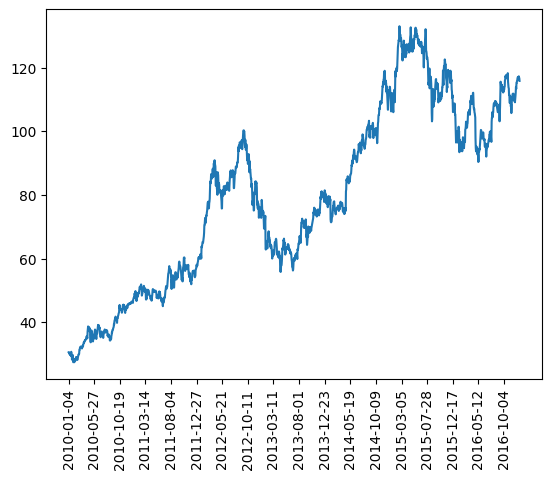

In [6]:
plt.plot(df.index, df['close'])
plt.xticks(range(0, len(list(df.index)), 100), list(df.index)[::100], rotation=90)
plt.show()

In [7]:
df['date'] = df.index
df['date'] = pd.to_datetime(df['date'])
df.head()

,open,close,low,high,volume,date
date,,,,,,
2010-01-04,30.490000,30.572857,30.340000,30.642857,123432400.0,2010-01-04
2010-01-05,30.657143,30.625713,30.464285,30.798571,150476200.0,2010-01-05
2010-01-06,30.625713,30.138571,30.107143,30.747143,138040000.0,2010-01-06
2010-01-07,30.250000,30.082857,29.864286,30.285715,119282800.0,2010-01-07
2010-01-08,30.042856,30.282858,29.865715,30.285715,111902700.0,2010-01-08


# Step 2: Scale the data

In [93]:
# Scaling the data
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

dataset = min_max_scaler.fit_transform(df[['open','low','high','volume']])
y_scaled = y_scaler.fit_transform(df[['close']])
dataset = np.concatenate((dataset, y_scaled), axis=1)


In [94]:
dataset[0:10]

array([[0.02812312, 0.03033377, 0.02480624, 0.24403431, 0.02971784],
       [0.02968552, 0.03152627, 0.02626779, 0.30298234, 0.03021854],
       [0.02939173, 0.02809952, 0.02578509, 0.27587485, 0.02560389],
       [0.02587968, 0.02576932, 0.02145406, 0.23498933, 0.02507612],
       [0.02394337, 0.02578302, 0.02145406, 0.21890274, 0.0269707 ],
       [0.02728183, 0.02494689, 0.02279493, 0.22686898, 0.02444008],
       [0.0224611 , 0.02216434, 0.01846388, 0.29892522, 0.02120576],
       [0.02069841, 0.0189843 , 0.0200193 , 0.30515509, 0.02517085],
       [0.02368966, 0.02572819, 0.01938909, 0.2108831 , 0.02351986],
       [0.02478467, 0.02141046, 0.02091769, 0.29871161, 0.0187834 ]])

In [95]:
dataset.shape

(1762, 5)

# Step 3: Train test split data

In [96]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1233 529


In [97]:
train

array([[0.02812312, 0.03033377, 0.02480624, 0.24403431, 0.02971784],
       [0.02968552, 0.03152627, 0.02626779, 0.30298234, 0.03021854],
       [0.02939173, 0.02809952, 0.02578509, 0.27587485, 0.02560389],
       ...,
       [0.81725311, 0.84120351, 0.834053  , 0.06957593, 0.84189727],
       [0.84155702, 0.85252557, 0.84071716, 0.09962082, 0.84341296],
       [0.83538752, 0.85818663, 0.8519805 , 0.07841537, 0.86387439]])

# Step 4: Create data of sequences for LSTM

In [129]:
def create_sequences(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 4]) # column with index 4 is close value which we want to predict
    return np.array(dataX), np.array(dataY)

In [130]:
x_train, y_train = create_sequences(train, look_back=15)
x_test, y_test = create_sequences(test, look_back=15)

In [131]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1217, 15, 5)
(1217,)
(513, 15, 5)
(513,)


In [61]:
#The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: 
#    [samples, time steps, features].

#Currently, this data is in the form: [samples, features] and we are framing the problem as one time step for each sample.
#We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:
# you can also use x_train = np.reshape(x_train, (x_train.shape[0], 3, 5)) as input. 
# This becomes a case where 3 time steps are considered along with 5 look back examples for each time step

#It's recommended to experiment with different time_step values and observe the model's performance on a validation set 
# to determine the most suitable value for your specific time series prediction task.


# Step 5: Create and fit the LSTM network

In [133]:


model = Sequential()
model.add(LSTM(10, input_shape=(15, 5))) # hyperbolic tangent (tanh) activation function used by default
model.add(Dense(1)) # linear activation function is used by default
model.compile(loss='mean_squared_error', optimizer='adam')
#'adam' is a popular optimization algorithm that adapts the learning rates of each parameter individually, 
#making it well-suited for a wide range of tasks. Adam is an extension of stochastic gradient descent (SGD) 
#and is known for its efficiency in training deep neural networks.
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                640       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 651 (2.54 KB)
Trainable params: 651 (2.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [134]:
# epochs represent how many times model traning happens through whole dataset
# batch_size represents number of examples considered in each iteration within epoch
# in this we will have 1220/10 : 122 iterations
model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=2)

Epoch 1/20
122/122 - 2s - loss: 0.0398 - 2s/epoch - 17ms/step
Epoch 2/20
122/122 - 0s - loss: 5.7768e-04 - 499ms/epoch - 4ms/step
Epoch 3/20
122/122 - 0s - loss: 4.0412e-04 - 451ms/epoch - 4ms/step
Epoch 4/20
122/122 - 0s - loss: 3.8345e-04 - 471ms/epoch - 4ms/step
Epoch 5/20
122/122 - 0s - loss: 3.5592e-04 - 472ms/epoch - 4ms/step
Epoch 6/20
122/122 - 1s - loss: 3.3361e-04 - 502ms/epoch - 4ms/step
Epoch 7/20
122/122 - 0s - loss: 3.1329e-04 - 488ms/epoch - 4ms/step
Epoch 8/20
122/122 - 0s - loss: 2.9438e-04 - 466ms/epoch - 4ms/step
Epoch 9/20
122/122 - 0s - loss: 2.8193e-04 - 453ms/epoch - 4ms/step
Epoch 10/20
122/122 - 0s - loss: 2.7051e-04 - 497ms/epoch - 4ms/step
Epoch 11/20
122/122 - 0s - loss: 2.6008e-04 - 496ms/epoch - 4ms/step
Epoch 12/20
122/122 - 0s - loss: 2.5208e-04 - 465ms/epoch - 4ms/step
Epoch 13/20
122/122 - 0s - loss: 2.4188e-04 - 455ms/epoch - 4ms/step
Epoch 14/20
122/122 - 0s - loss: 2.2698e-04 - 477ms/epoch - 4ms/step
Epoch 15/20
122/122 - 0s - loss: 2.2483e-04 - 466

In [139]:
# Few examples of time series evaluation
def errors(prediction,actual): 
    mae = np.mean(np.abs(prediction - actual))
    mape = np.mean(np.abs(prediction - actual)/np.abs(actual))*100
    rmse = np.mean((prediction - actual)**2)**0.5
    return({'mae':mae,'mape':mape,'rmse':rmse})

In [140]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)


# invert predictions and labels
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

errors(trainPredict[:,0],trainY[0])
#errors(trainPredict[:,0],trainY[0]) - add on the test data as well

# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
#print('Test Score: %.2f RMSE' % (testScore))

17/17 [==============================] - 0s 2ms/step


{'mae': 1.069218559316453,
 'mape': 1.6959939518991372,
 'rmse': 1.4327226542081368}

In [ ]:
# 1.69%
# 0.1 %

# Step 6: Visualization of predicted outut

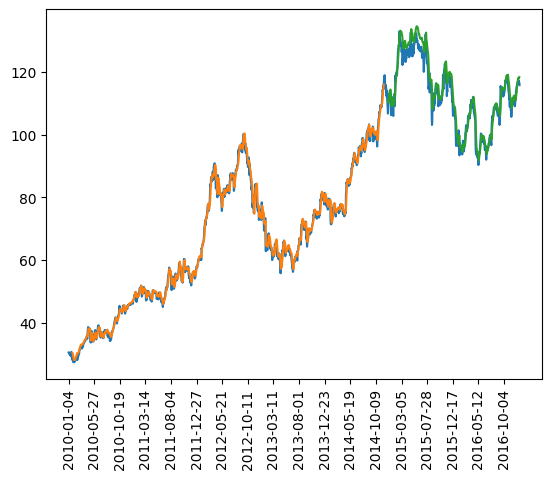

In [141]:
look_back = 15
# shift train predictions for plotting
trainPredictPlot = np.empty_like(y_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(y_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
#plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(df['close'])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xticks(range(0, len(list(df.index)), 100), list(df.index)[::100], rotation=90)
plt.show()